### Theory

Bloom Filters were introduced and named by Burton Bloom (1970) as a way to yield quick responses to whether a given element was within a set of elements without having to store each individual element. It exploits a trade off between space and calculated error for problems in which there is low cost to false positives. 

Open addressing allowed us to operate hash tables with O(1) at each operation. However, (depending on the implementation) the size/memory required of the table increases as the set of elements to be stored increases. That is caused by each element being physically stored within the table and then accessed through the hash functions. This becomes computationally expensive as each element is contained within the table. 

Bloom reduced the informational content contained within each slot to whether the element has been encountered. That is instead of storing the element itself, an element that was fed to the algorithm leaves a mark in the slot that it accessed. Practically this means that each slot does not contain the element that accessed it through a hash function but simply a 0 if no element has accessed it or a 1 if it has been accessed. Each new element accesses the hash table through multiple hash functions leaving a unique imprint on the hash table by marking various spots. Imagine the profile of a shoe that leaves marks in the snow only in spots unique to the shoe's profile. When we now test if an element is a part of the set that has been passed to the table before, we simply check if all slots the element should have marked are equal to 1. More formally, each element $n_a$ of set $N$ will be passed through a k-sized set $H$ of hash functions $h_1, ..., h_k$. Then, in a hash table $B$ each $B[h_i(n_a)]$ will be set to 1. 

Bloom Filteres do have a chance of false positives however. I.e., when we identify an element $n_x$ to be part of $N$ when it is not. Such an error occurs if previously passed elements have set the markers corresponding to $n_x$ to 1. 
Imagine the case that we have k = 3 hash functions $h_1, h_2, h_3$ and are checking if an element $n_4$ is part of $N$. We have previously passed $n_1, n_2, n_3$ who are part of $N$ to $B$. If now: 

$B[h_1(n_1)]$ = $B[h_1(n_4)]$

$B[h_2(n_2)]$ = $B[h_2(n_4)]$

$B[h_3(n_3)]$ = $B[h_3(n_4)]$

then we consider $n_4$ to be part of N even though it is not. We could minimize the false positive likelihood simply by increasing k. However, this would mean that $B$ would need to increase to avoid few elements to just fill up the entire table. Consider for the example illustrated in Fig. 1. 
Aside from the added overhead of calculated the additional hash value, we are also increasing the table's required memory which is exactly what we were optimizing for in the first place. Hence, we are dealing with another trade off: Increase k and hence memory and overhead or accept larger error. Therefore, it using an apppropriate uniformly hashing function is imperative.

Mathematically, the false positive rates for a bloom filter is the probability that for an element passed to the filter, none of the slots are zero. In a Bloom Filter of size m bits, k hash functions, and n set members the probability of having a zero in a slot is: 

$P(B[i] = 0) = (1-\frac{1}{m})^{kn}$

Hence the probability of a false positive p is: 

$p = (1 - (1-\frac{1}{m})^{kn})^k \approx (1 - e^{kn/m})^k$

We can minimize the above function for an optimal number of hash functions k at:

$k = ln (2) \frac{m}{n}$. 

Hence, the false positive rate is given at:

$(\frac{1}{2})^k = (0.6185)^{m/n}$. 

(Cao, 1998)


Consequently, we can calculate the size of the given bloom filter if we have a given false positive probability p and an expected input size n: 

$m = \frac {n * log(\frac{1}{p})}{log^2 (2)}$

(Cortesi, 2010)

## Applications


#### Spell Checker 

A typical example is a spell checking function of whether a word is part of a dictionary of common words. In that case we can pass the a list of commonly misspelled word to our filter upon creation and then check each word in the text on whether it is part of the filter. The cost of false positives is relatively small as if a correctly spelled word is identified as misspelled, the user can override the feedback. The cost of storing the words becomes reduced significantly through the use of the BF.

#### High Risk Customer

Image a bank that to comply with financial crime prevention laws has to monitor the activity of its clients for certain patterns. A screening program might frequently push out customers that have shown risky behavior. We can now use a BF to assess whether the customer has previously been identified has having a high risk factor. If they do we can alert a human assessment of the situation. In this case we minimize the amount of human resources needed through a simple bloom filter application.

#### Banning Websites

Many companies, schools, and household will for various reasons want to ban access to specific websites such as Facebook to avoid distraction. Using a Bloom Filter we keep adding the IP addresses of the websites to the filter and before any website can be accessed the BF provides a fast and efficient way of checking if it is banned. This example will be used henceforth.



### Hash Function

A suitable hash function in this context will be fast, hash uniformly, avoid collision, and extendable to accomodate for multiple k. Extensive research has been put into creating efficient hash functions. The avalanche test is a common method to test how well a hash function deals with similar input. It measures how close two hash values are that are derived from inputs that differ by e.g. 1 bit. As determined by Estébanez, Saez, Recio, & Isasi (2014) the murmur hash was among the most efficient hash functions. It was first developed by Austin Appleby in 2008. The function splits the input into 32-bit-sized pieces and multiplies, rotates (about 15 times) and applies XOR with different seed values to the input (Appleby, 2011; Senuma, 2017). The implementation lets the user specify the element and the seed value which in our case is a convenient way to implement k hash functions. While Estébanez, Saez, Recio, & Isasi (2014) tested Murmur Hash 2, this implementation uses the more up-to-date murmurhash 3 (Senuma, 2017).

In [1]:
!pip install mmh3
import math
import mmh3
import random as rd
import matplotlib.pyplot as plt

In [0]:
#initialize the bloom filter class
class bloom():
    
    #our filter takes as inputs the size of the input and the desired false positive rate
    def __init__(self, n, p):
        
        #calculate the memory size of the BF
        self.size = math.ceil(n * math.log(1/p) / (math.log(2)*math.log(2)))
        
        #set up a table filled with 0 markers
        self.table = [0]*(self.size)
        
        #find the number of hash functions
        self.optimal_k = math.ceil(math.log(2)*(self.size/n))
     
    #Insertion method
    def insert(self, elem):
        
        #for every hash function
        for i in range(self.optimal_k):
            
            #retrieve the hash value
            h_value = mmh3.hash(str(elem), i)%self.size
            
            #set the marker to 1
            self.table[h_value] = 1
    
    
    #Check Method
    def check(self, elem):
        
        #for every hash function
        for i in range(self.optimal_k):
            
            #retrieve hash value
            h_value = mmh3.hash(str(elem), i)%self.size
            
            #check if the marker has been set to 1
            if self.table[h_value] != 1:
                #return as soon as a marker is not 1
                return False
        
        #if all markers were 1, return True
        return True
        

In [3]:
## Let's test the BF
#create a list of banned IPs of length 32-integers. 
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10000)]

#initialize the bloom filter with false positive rate of 5%
BF = bloom(len(bad_IP),0.05)

#insert the bad_IPs into the filter
for something in bad_IP:
  BF.insert(something)

## Adding 10 elements that are definitely not in the BF
test = bad_IP + [1,2,3,4,5,6,7,8,9,10]

## Check if the values are being recognized as not part of the filter
for something in test: 
  if BF.check(something):
    continue
  else: 
    print(something)

1
2
3
4
5
6
7
8
9
10


In [4]:
## Check if the false positive rate is accurate
# The length of each element in the list one less than that of the good IPs so I am certain they are not part of the filter
# We should expect that approximately 5000 elements are recognized as being part of the filter as n = 100,000.
good_IPs = [rd.randrange(1000000000000000000000000000000,9999999999999999999999999999999) for _ in range(100000)]

## Check if the values are being recognized as not part of the filter
error = 0
for something in good_IPs: 
  if BF.check(something):
    error += 1
print(f"{error} elements were falsely recognized to be part of the filter")
print(f"The false positive rate is {(error / 100000)*100}%")

5083 elements were falsely recognized to be part of the filter
The false positive rate is 5.083%


Our simple bloom filter works! 

But what about the case in which we would like our users to be able to use a website again because it has become appropriate to use. That is hwo can we delete an element from our BF? 

## Counting Bloom Filters

A major limitation to the simple BF above is that it does not allow for deletion of elements from the data. That is because we cannot set the corresponding slots to 0 for an element without risking that a single slot is accessed by multiple elements. Counting Bloom Filters (CBF) work around this problem through loosening the restriction of the table contents. Instead of setting a slot to 1 when it is accessed, we increment the slot by 1. Hence, when we delete the value we can just decrement the slot by 1. Consequently, we can still check if an element exists in the filter through testing if a slot has a value of $\theta$ or above (Kim, Jeong, Lee, & Lee, 2019). 
With $\theta$ we have now introduced another parameter in our probability function for false positives. Through a binomial distribution we can find the probability $b$ that a given slot has some value $l$ in a CBF with k hash functions, n elements and size m. 

$b(l, kn, \frac{1}{m}) = \binom{kn}{l} (\frac{1}{m})^l (1 - \frac{1}{m})^{kn - l}$

This equation reduces down as we set $l = 0$ to test for complete absence of the element:

$b(0, kn, \frac{1}{m}) = (1 - \frac{1}{m})^{kn}$

The probability of an element being shown as marked $\theta$ times if it has not been is 1 minus sum of the probabilities that has $l < \theta$ to the power of k: 

$p(\theta, n, m, k) = (1 - \sum_{l < \theta} {b(l, kn, \frac{1}{m}}))^k$

(Kim, Jeong, Lee, & Lee, 2019)

In our simple bloom filter above calculating the ideal size and number of k was was easily derived. However as shown in Kim, Jeong, Lee, & Lee (2019) the calculations for CBFs become rather complex and as such computationally expensive due to the binomial distributions. Hence, in our implementation of the CBF we will keep using the old less optimal values for size and k. 

In [0]:
#initialize the bloom filter class
class counting_bloom():
    
    #our filter takes as inputs the size of the input and the desired false positive rate
    def __init__(self, n, p):
        
        #calculate the memory size of the BF
        self.size = math.ceil(n * math.log(1/p) / (math.log(2)*math.log(2)))
        
        #set up a table filled with 0 markers
        self.table = [0]*(self.size)
        
        #find the number of hash functions
        self.optimal_k = math.ceil(math.log(2)*(self.size/n))
     
    #Insertion method
    def insert(self, elem):
        
        #for every hash function
        for i in range(self.optimal_k):
            
            #retrieve the hash value
            h_value = mmh3.hash(str(elem), i)%self.size
            
            #set the marker to 1
            self.table[h_value] += 1
    
    
    #Check Method
    def check(self, elem, theta):
        
        #check for theta
        if theta <= 0:
          return "theta must be larger 0 to test for existence in filter"

        #for every hash function
        for i in range(self.optimal_k):
            
            #retrieve hash value
            h_value = mmh3.hash(str(elem), i)%self.size
            
            #check if the marker is smaller theta
            if self.table[h_value] < theta:
                #return as soon as a marker is not theta
                return False
        
        #if all markers were 1, return True
        return True

    #create a deletion method
    def delete(self, elem):
       #for every hash function

        #check if element is even in the hash function
        if self.check(elem, 1) == False:
          return "Element not in bloom filter"

        #for each marker
        for i in range(self.optimal_k):
            
            #retrieve the hash value
            h_value = mmh3.hash(str(elem), i)%self.size

            
            #decrement the marker
            self.table[h_value] -= 1
    

In [6]:
## Let's test the CBF
#create a list of banned IPs of length 32-integers. 
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10000)]

#initialize the bloom filter with false positive rate of 5%
CBF = counting_bloom(len(bad_IP),0.05)

#insert the bad_IPs into the filter
for something in bad_IP:
  CBF.insert(something)

## Adding 10 elements that are definitely not in the BF
test = bad_IP + [1,2,3,4,5,6,7,8,9,10]

## Check if the values are being recognized as not part of the filter
for something in test: 
  if CBF.check(something, 1):
    continue
  else: 
    print(something)

1
2
3
4
5
7
8
9
10


In [7]:
## Check if the false positive rate is accurate
# The length of each element in the list one less than that of the good IPs so I am certain they are not part of the filter
# We should expect that approximately 5000 elements are recognized as being part of the filter as n = 100,000.
good_IPs = [rd.randrange(1000000000000000000000000000000,9999999999999999999999999999999) for _ in range(100000)]

## Check if the values are being recognized as not part of the filter
error = 0
for something in good_IPs: 
  if CBF.check(something, 1):
    error += 1
print(f"{error} elements were falsely recognized to be part of the filter")
print(f"The false positive rate is {(error / 100000)*100}%")

5244 elements were falsely recognized to be part of the filter
The false positive rate is 5.244%


In [8]:
#Now lets check if the deletion method works 

#check that the elements are being recongized as being part of the CBF
identified = 0
for element in bad_IP[0:50000]:
  if CBF.check(element, 1):
    identified += 1

print(f"Before deletion: \n {identified/len(bad_IP[:50000])*100}% of elements were correctly identified to be part of the filter")

#delete have the list out of the filter.
for element in bad_IP[:50000]:
  CBF.delete(element)

#test if the deleted elements are still in the filter
error = 0
for element in bad_IP[:50000]:
  if CBF.check(element, 1):
    error += 1

print(f"After Deletion: \n {error} elements were falsely recognized to be part of the filter")
print(f"The false positive rate is {(error / 100000)*100}%")


Before deletion: 
 100.0% of elements were correctly identified to be part of the filter
After Deletion: 
 0 elements were falsely recognized to be part of the filter
The false positive rate is 0.0%


None of the deleted elements were recognized as being part of the filter even though they were all recognized as being part of the filter before deletion. The CBF works!

## Analysis

### Memory vs theta vs input size

As described in the general analysis of the parameters of the BF and CBF, I have choosen to change the memory size depending on the function: 

$m = \frac {n * log(\frac{1}{p})}{log^2 (2)}$

Theoretically this is the function for how m changes with respect to the false positive rate (when keeping n constant) and with respect to the input size when keeping the desired false positive rate constant. 

A graphical representation of this function is given below in Figure 2. 

(Note: Throughout the analysis I am assuming that the input size is the length of the input list. This assumption is valid since our filter merely cares about an individual "existing" not its size. 

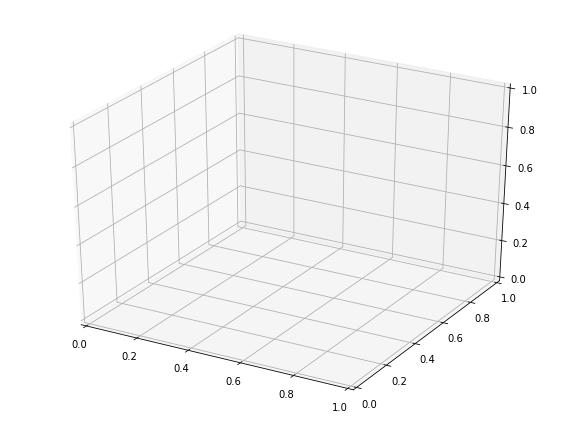

In [9]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
fig = plt.figure(figsize= (10,7.5))
ax = plt.axes(projection='3d')

def f(p, n):
    return (n * np.log(1/(p/100)) / (math.log(2)*math.log(2)))

ps = np.linspace(1,100,2)
ns = np.linspace(100, 10**6, 10000)

ps, ns = np.meshgrid(ps, ns)
ms = f(ps, ns)

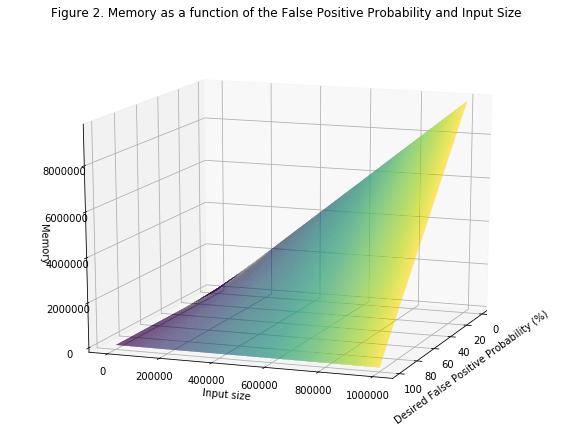

In [10]:
ax.plot_surface(ps, ns, ms, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('Figure 2. Memory as a function of the False Positive Probability and Input Size');
ax.set_xlabel('Desired False Positive Probability (%)')
ax.set_ylabel('Input size')
ax.set_zlabel('Memory');

ax.view_init(15, 20)

fig

In [0]:
import sys

In [0]:
## Find different memory depending on p with constant n = 10000

#create list to feed to filter
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10000)]

#counters
memories = []
probs = []

for prob in range(1, 1000):
  probs.append(prob)
  CBF = counting_bloom(len(bad_IP), prob/1000)
  for elem in bad_IP:
    CBF.insert(elem)
  memories.append(sys.getsizeof(CBF.table))

#get just the theoretical memory
t_mem = []
for p in range(1,1000):
  t_mem.append(10000 * np.log(1/(p/1000)) / (math.log(2)*math.log(2)))

Text(0.5, 1.0, 'Figure 3b. False Postive Rate vs. Memory (Theoretical)')

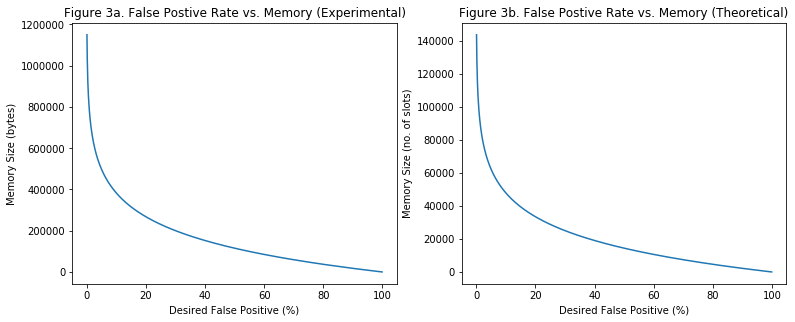

In [13]:
plt.figure(figsize= (12.8, 4.8))
plt.subplot(1,2,1)
plt.plot([prob/10 for prob in probs], memories)
plt.xlabel("Desired False Positive (%)")
plt.ylabel("Memory Size (bytes)")
plt.title("Figure 3a. False Postive Rate vs. Memory (Experimental)")

plt.subplot(1,2,2)
plt.plot([prob/10 for prob in probs], t_mem)
plt.xlabel("Desired False Positive (%)")
plt.ylabel("Memory Size (no. of slots)")
plt.title("Figure 3b. False Postive Rate vs. Memory (Theoretical)")

Text(0.5, 1.0, 'Figure 4. False Postive Rate vs. Memory for the first 10%')

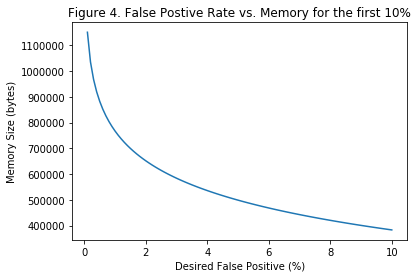

In [14]:
plt.plot([prob/10 for prob in probs][:100], memories[:100])
plt.xlabel("Desired False Positive (%)")
plt.ylabel("Memory Size (bytes)")
plt.title("Figure 4. False Postive Rate vs. Memory for the first 10%")

As shown in Fig. 3 (a) and (b), the memory size scales exactly with like the desired function discussed in the theorical part above (note the different magnitudes due to different units). The higher the false positive rate the lower the required memory. Especially at small false positive rates (Fig. 4) the exponential growth of memory size with smaller desired p becomes apparent. The result matches the intuitive approach that if we want to minimize the collisions, we have to increase the number of possible slots and so also the likelihood of a match when there is none. 

In [0]:
##Let's do the reverse and measure the memory size with a set probability at 5%. 

#create list to feed to filter
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10**6)]

#counters
memories = []
n_store = []

for n_len in range(1, 10**6, 10000):
  n_store.append(n_len)
  CBF = counting_bloom(n_len, 0.05)
  for elem in bad_IP[:n_len]:
    CBF.insert(elem)
  memories.append(sys.getsizeof(CBF.table))

#get just the theoretical memory
t_mem = []
for n in range(1, 10**6, 10000):
  t_mem.append(n * np.log(1/0.05) / (math.log(2)*math.log(2)))

Text(0.5, 1.0, 'Figure 5b. Input Size vs. Memory (Theoretical)')

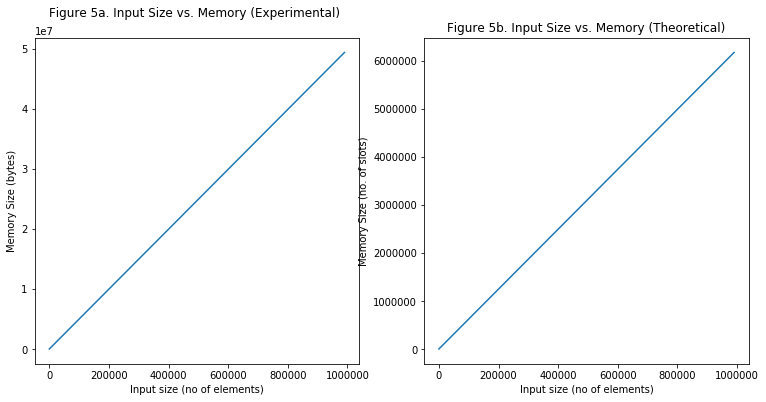

In [16]:
plt.figure(figsize= (12.8, 6.0))
plt.subplot(1,2,1)
plt.plot(n_store, memories)
plt.xlabel("Input size (no of elements)")
plt.ylabel("Memory Size (bytes)")
plt.title("Figure 5a. Input Size vs. Memory (Experimental) \n")

plt.subplot(1,2,2)
plt.plot(n_store, t_mem)
plt.xlabel("Input size (no of elements)")
plt.ylabel("Memory Size (no. of slots)")
plt.title("Figure 5b. Input Size vs. Memory (Theoretical)")

The equation to calculate the size of inputs becomes a simple linear equation: 

$m = \frac {n * log(\frac{1}{p})}{log^2 (2)}$

$m = n * \frac {log(\frac{1}{0.05})}{log^2 (2)}$

$m = c*n$

This linear equation is exhibited in Figure 5 a and b as memory grows linearly with the input size. Again the magnitudes differ as in the theoretical equation we only calculate the number of slots i.e. the lenght of the table instead of the memory each slot requires. 

The access time should only increase marginally as it is depending on k which is found using the optimal number of hash functions for the regular BF.

$k = ln  (2)  \frac{m}{n}$

That is we expect O(k).

Let's see if this is replicated in the experimental approach:

In [0]:
import time

In [0]:
## Find different memory depending on p with constant n = 10000

##Note, that we are only checking elements that are actually in the filter.

#create list to feed to filter
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10000)]

#counters
times = []
probs = []

for prob in range(1, 1000):
  probs.append(prob)
  CBF = counting_bloom(len(bad_IP), prob/1000)
  for elem in bad_IP:
    CBF.insert(elem)

  #find the mean access time for 100 elements
  one_p = []
  for _ in range(100):
    start_t = time.time()
    #randomly choose an element to be accessed
    CBF.check(rd.choice(bad_IP), 1)
    one_p.append(time.time() - start_t)

  times.append(np.mean(one_p))


#get just the theoretical memory
t_time = []
for p in range(1,1000):
  t_time.append((math.log(2)*(np.log(1/(p/1000)) / (math.log(2)*math.log(2)))))

Text(0.5, 1.0, 'Figure 6b. False Postive Rate vs. Hash Functions (Theoretical)')

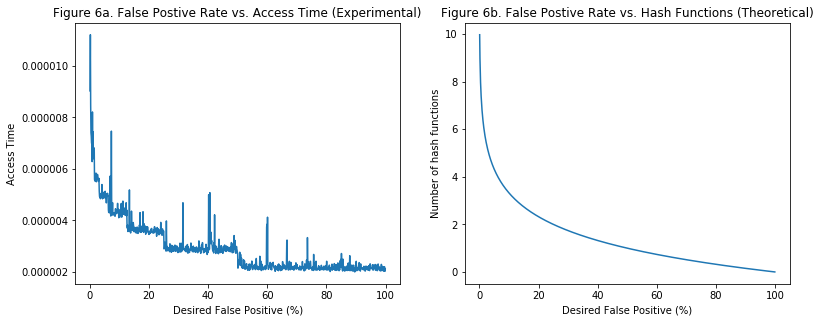

In [19]:
plt.figure(figsize= (12.8, 4.8))
plt.subplot(1,2,1)
plt.plot([prob/10 for prob in probs], times)
plt.xlabel("Desired False Positive (%)")
plt.ylabel("Access Time")
plt.title("Figure 6a. False Postive Rate vs. Access Time (Experimental)")

plt.subplot(1,2,2)
plt.plot([prob/10 for prob in probs], t_time)
plt.xlabel("Desired False Positive (%)")
plt.ylabel("Number of hash functions")
plt.title("Figure 6b. False Postive Rate vs. Hash Functions (Theoretical)")

As expected, the number of slots needed to be accessed decreases logarithmically. However, in my experimental approach (Fig. 6a) we can observe a step size pattern which originates from the math.ceil function that rounds k to the upper bound. I chose this so that for large false positive rates, k would become zero otherwise. (Note the additional overhead from choosing a new element). However, functionally we observe the same functional form in both cases, confirming that access time scales at O(k). 

We cannot expect a change of access time with respect to $n$ because as we have seen the in Fig. 5 the memory grows linearly depending on n. When we now substitute this relationship back into the function for k we see that k becomes dependent soley on $p$ which we hold constant in this case: 

$k = ln  (2)  \frac{m}{n}$

$m = n * \frac {log(\frac{1}{0.05})}{log^2 (2)}$

$m = c*n$

$k = ln  (2)  \frac{c*n}{n}$

$k = c * ln  (2)$

Let's see if we can observe this in the experimental results as well: 

In [0]:
#create list to feed to filter
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(10**6)]

#counters
t_store = []
n_store = []
k_store = []


for n_len in range(1, 10**6, 10000):
  n_store.append(n_len)
  CBF = counting_bloom(n_len, 0.05)
  k_store.append(CBF.optimal_k)
  for elem in bad_IP[:n_len]:
    CBF.insert(elem)
  
  #mean access time for a hundred accesses
  one_n = []
  for _ in range(1000):
    elem = rd.choice(bad_IP[:n_len])
    start_t = time.time()
    #randomly choose a element to be accessed
    out = CBF.check(elem, 1)
    one_n.append(time.time() - start_t)

  t_store.append(np.mean(one_n))

In [0]:
#get just the theoretical memory
t_time_n = []
for n in range(1, 10**6, 10000):
  t_time_n.append(np.log(2))

Text(0.5, 1.0, 'Figure 7c. n vs. Hash Functions (Theoretical)')

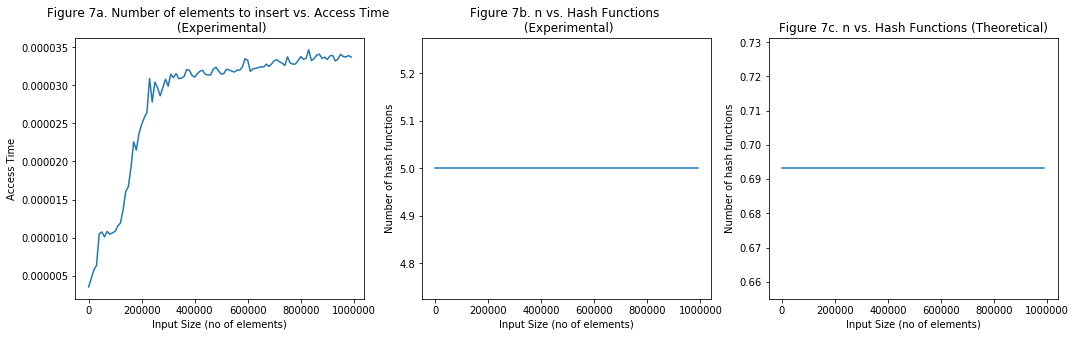

In [22]:
plt.figure(figsize= (17.6, 4.8))
plt.subplot(1,3,1)
plt.plot(n_store, t_store)
plt.xlabel("Input Size (no of elements)")
plt.ylabel("Access Time")
plt.title("Figure 7a. Number of elements to insert vs. Access Time \n (Experimental)")

plt.subplot(1,3,2)
plt.plot(n_store, k_store)
plt.xlabel("Input Size (no of elements)")
plt.ylabel("Number of hash functions")
plt.title("Figure 7b. n vs. Hash Functions \n (Experimental)")

plt.subplot(1,3,3)
plt.plot(n_store, t_time_n)
plt.xlabel("Input Size (no of elements)")
plt.ylabel("Number of hash functions")
plt.title("Figure 7c. n vs. Hash Functions (Theoretical)")

As shown in Fig. 7a the number access time increases with the number of input elements. This is in contrast to the theoretical expectations of the access time growing with O(k) because as we see in Fig. 7b and 7c the number of hash functions does not depend on n. I assume that this is due to some computational overhead from having to access an element from a larger overall memory. Hence, we can conclude that practically the input size (which has an effect on the memory) matters even though not through the number of accesses made but the computational expense of each access. 

### Desired vs. Achieved False Positive Rates

In [0]:
## Let's check how well our desired false positive probabilies are matched: 

#Let's create a hundred thousand bad IPs and a ten thousand good IPs
#Good IPs simply have one less integer than the bad ones. 
bad_IP = [rd.randrange(10000000000000000000000000000000,99999999999999999999999999999999) for _ in range(100000)]
good_IP =[rd.randrange(1000000000000000000000000000000, 9999999999999999999999999999999) for _ in range(10000)]


rec_p = []
rec_rate = []
rec_k = []

for p in range(1, 100):
  rec_p.append(p/100)

  #create a CBF with varying p
  CBF = counting_bloom(len(bad_IP), p/100)
  rec_k.append(CBF.optimal_k)

  #insert the bad IPs into the CBF
  for elem in bad_IP:
    CBF.insert(elem)

  false_positive = 0
  #check the good IPs
  for elem in good_IP:
    if CBF.check(elem, 1):
      false_positive += 1

  rec_rate.append(false_positive/10000)


Text(0.5, 1.0, 'Figure 8c. Change in k over desired false positive rate')

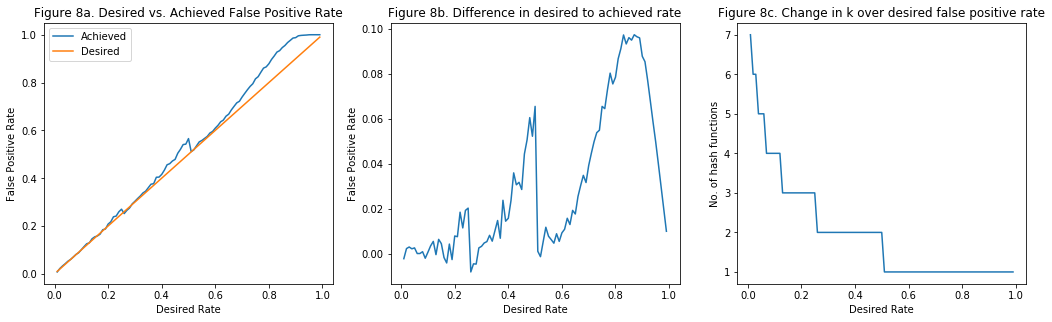

In [31]:
plt.figure(figsize= (17.6, 4.8))
plt.subplot(1,3,1)
plt.title("Figure 8a. Desired vs. Achieved False Positive Rate")
plt.plot(rec_p, rec_rate)
plt.plot(rec_p, rec_p)
plt.xlabel("Desired Rate")
plt.ylabel("False Positive Rate")
plt.legend(("Achieved","Desired"))

plt.subplot(1,3,2)
plt.title("Figure 8b. Difference in desired to achieved rate")
plt.xlabel("Desired Rate")
plt.ylabel("False Positive Rate")
plt.plot(rec_p,[rec_rate[i] - rec_p[i] for i in range(len(rec_p))])

plt.subplot(1,3,3)
plt.plot(rec_p, rec_k)
plt.xlabel("Desired Rate")
plt.ylabel("No. of hash functions")
plt.title("Figure 8c. Change in k over desired false positive rate")

My achieved false positive rate is relatively accurate (Fig. 8a) but as shown in Fig. 8b and 8c the ceiling function has a large affect on the achieved false positive rate. The larger the desired false positive rate, the longer the intervals of a slighly off number of hash functions is. This lets us observe a practical limitation of the calculations of the optimal k because it needs to be ≥ 1 and be an integer for the hashing to actually work. 

Aside from that the differences shown in 8a are relatively small with small desired false positive rates having the smallest differences all varying by a small margins shown in Fig. 9.

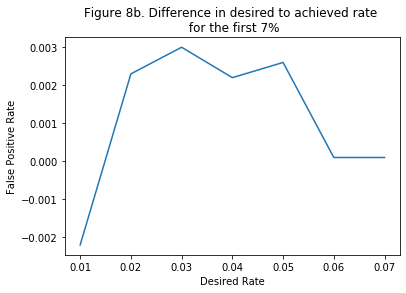

In [34]:
plt.title("Figure 8b. Difference in desired to achieved rate \n for the first 7%")
plt.xlabel("Desired Rate")
plt.ylabel("False Positive Rate")
plt.plot(rec_p[:7],[rec_rate[i] - rec_p[i] for i in range(7)])

## Corner Cases


* The hash function is not really optimal because we have to have an integer. As discussed above, the limitation of the filter does not lead to an exact desired false positive probability. 

* The elements to be added need to be known before. Without knowing the length of the input list, the CBF cannot calculate the memory size or the number of hashfunctions. To void this we would have to re-hash the entire table with a bigger table size and more hash functions to maintain the desired false positive probability. Otherwise, the false positive rate achieved will increase for each extra element. 

* Deleting false positives. As shown in my deletion function, I check if elements are actually in the filter. I do this to avoid having negative values in my slots. However, in p% of cases a element could be falsely let through this filter and be deleted even though it was never part of the filter in the first place. Such a change would then ripple through to all the elements with connections to this slot as the slots have been decremented even though they should not have been. 

## HCs 

* #rightproblem: I identify the problem the BF/CBF is trying to solve as one of trying to reduce memory by optimizing the amount of information that needs to be stored. Through my analysis I give walk through my approach to solving the problem and identifying relevant aspects (i.e. how to choose m). 

* #optimization: By using mathematical optimization techniques, am able construct BF and CBFs that perform almost optimally. I give a clear walk through of why my choice of k and m is optimal and discuss the effects on it in various parts of the paper (see discussion of having to use a ceiling function), thereby effectively critiquing the optimization's implementation and its consequences. 

* #algorithms: By using a python-class I am able to implement and explain a sophisticated piece of code through detailed steps. I provide thorough explanation of my code. 

## Works Cited

Appleby, A. (2011). MurmurHash. Retrieved from sites.google.com: https://sites.google.com/site/murmurhash/

Bloom, B. H. (1970). Space/time trade-offs in hash coding with allowable errors. Communications of the ACM, 422-426.

Bonomi, F., Mitzenmacher, M., Panigrahy, R., Singh, S., & Varghese, G. (2006). An improved construction for counting bloom filters. European Symposium on Algorithms (pp. 684-695). Berlin, Heidelberg: Springer.

Cao, P. (1998). Summary Cache: A Scalable Wide-Area Web Cache Sharing Protocol. Retrieved from Bloom Filters - the math: http://pages.cs.wisc.edu/~cao/papers/summary-cache/node8.html

Cortesi, A. (2010, 08 25). 3 Rules of thumb for Bloom Filters. Retrieved from corte.si: https://corte.si/posts/code/bloom-filter-rules-of-thumb/index.html

Estébanez, C., Saez, Y., Recio, G., & Isasi, P. (2014). Performance of the most common non-cryptographic hash functions: Performance of the most common non-cryptographic hash functions. Software: Practice and Experience, 681-698.

Kim, K., Jeong, Y., Lee, Y., & Lee, S. (2019). Analysis of Counting Bloom Filters Used for Count Thresholding. Electronics, 8(7), 779.

Senuma, H. (2017, 10 31). pypi.org. Retrieved from mmh3 2.5.1: https://pypi.org/project/mmh3/
